Dataset: https://docs.google.com/spreadsheets/d/1DbJaRjfcw41a5Ncvk9m7MIAgew0qmQuP/edit?usp=sharing&ouid=111943095037153006630&rtpof=true&sd=true

# Import Data

In [ ]:
import pandas as pd

df = pd.read_excel("cookie_cats.xlsx")

# Data Collection

In [ ]:
df.head(100)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
95,9443,gate_40,3,False,False
96,9589,gate_30,8,False,False
97,9699,gate_40,8,False,False
98,9828,gate_40,1,False,False


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [ ]:
df.describe()

,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


## Cek Missing Value

In [ ]:
df.isnull().sum()

,0
userid,0
version,0
sum_gamerounds,0
retention_1,0
retention_7,0


Data tidak ada missing value, jadi aman untuk proses dilakukan pengujian hipotesis testing pada A/B Testing

## Identifikasi Matrik yang Diukur

### User Engagement: Jumlah ronde permainan dalam 14 hari pertama

In [ ]:
engagement_stats = df.groupby("version")["sum_gamerounds"].describe()
print("\nUser Engagement :\n")
engagement_stats


User Engagement :



,count,mean,std,min,25%,50%,75%,max
version,,,,,,,,
gate_30,44700.0,52.456264,256.716423,0.0,5.0,17.0,50.0,49854.0
gate_40,45489.0,51.298776,103.294416,0.0,5.0,16.0,52.0,2640.0


Insight:
- Gate_40 tampaknya mengurangi pemain dengan jumlah ronde ekstrem (outliers) dibandingkan Gate_30, terlihat dari berkurangnya standar deviasi dan nilai maksimum.
- Rata-rata jumlah ronde yang dimainkan tetap hampir sama di kedua versi, yang berarti perubahan dari Gate_30 ke Gate_40 tidak secara signifikan memengaruhi engagement secara umum.

### Feature Interaction: Level maksimum yang dicapai oleh pemain

In [ ]:
retention_1 = df.groupby("version")["retention_1"].mean() * 100  # Persentase Retention D1
retention_7 = df.groupby("version")["retention_7"].mean() * 100  # Persentase Retention D7

print(f"Retention Day 1:\n{retention_1}")
print(f"Retention Day 7:\n{retention_7}")

Retention Day 1:
version
gate_30    44.818792
gate_40    44.228275
Name: retention_1, dtype: float64
Retention Day 7:
version
gate_30    19.020134
gate_40    18.200004
Name: retention_7, dtype: float64


Insight:
- Perubahan dari Gate_30 ke Gate_40 sedikit menurunkan retensi hari pertama, tetapi perbedaannya kecil. Ini menunjukkan bahwa perubahan tidak memiliki dampak besar terhadap keputusan pemain untuk kembali ke game setelah 1 hari.
- Retention turun lebih signifikan (**~0.82%**) setelah 7 hari di Gate_40. Ini menunjukkan bahwa perubahan dalam Gate_40 sedikit mengurangi daya tarik game dalam jangka panjang, menyebabkan lebih banyak pemain berhenti bermain dalam seminggu.

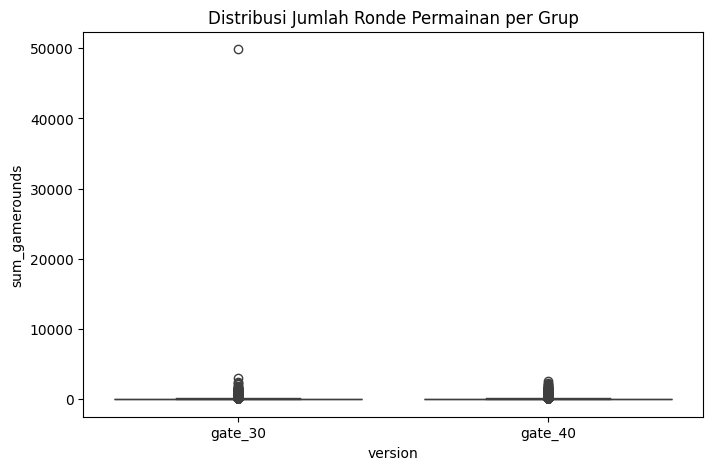

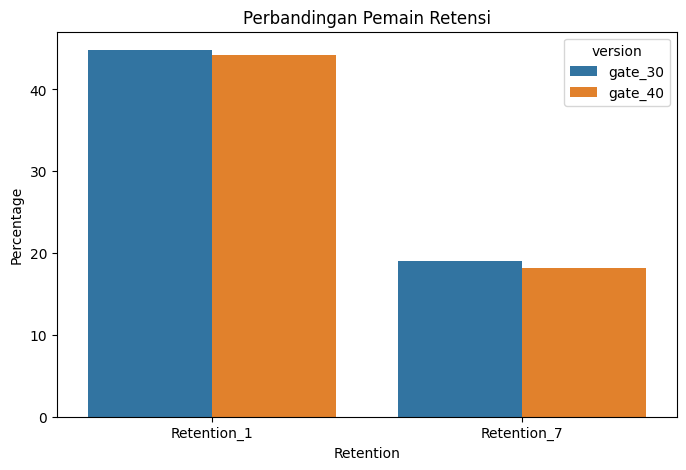

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
## Boxplot untuk melihat distribusi jumlah ronde permainan
plt.figure(figsize=(8,5))
sns.boxplot(x="version", y="sum_gamerounds", data=df)
plt.title("Distribusi Jumlah Ronde Permainan per Grup")
plt.show()

## Bar plot untuk user retention
retention_df = pd.DataFrame({
    "Retention_1": retention_1,
    "Retention_7": retention_7
}).reset_index().melt(id_vars=["version"], var_name="Retention", value_name="Percentage")

plt.figure(figsize=(8,5))
sns.barplot(x="Retention", y="Percentage", hue="version", data=retention_df)
plt.title("Perbandingan Pemain Retensi")
plt.show()

# Data Analysis


## Perhitungan Sampel

### Menentukan proporsi masing-masing gate dimana ketentuan pemain yang bermain > 10 ronde dianggap aktif

In [ ]:
import pandas as pd

threshold = 10  # Misalnya, pemain yang bermain lebih dari 10 ronde dianggap aktif
df_30 = df[df["version"] == "gate_30"]
df_40 = df[df["version"] == "gate_40"]

# Hitung proporsi pemain yang bermain lebih dari threshold ronde
p_30 = (df_30["sum_gamerounds"] > threshold).mean()
p_40 = (df_40["sum_gamerounds"] > threshold).mean()

print(f"Proporsi pemain gate_30 yang bermain lebih dari {threshold} ronde: {p_30:.2f}")
print(f"Proporsi pemain gate_40 yang bermain lebih dari {threshold} ronde: {p_40:.2f}")


Proporsi pemain gate_30 yang bermain lebih dari 10 ronde: 0.60
Proporsi pemain gate_40 yang bermain lebih dari 10 ronde: 0.60


### Menghitung Proporsi Pooled (gabungan)

In [ ]:
# Hitung ukuran sampel di masing-masing grup
n1 = len(df.loc[df["version"] == "gate_30", "sum_gamerounds"])  # Jumlah pemain di gate_30
n2 = len(df.loc[df["version"] == "gate_40", "sum_gamerounds"])  # Jumlah pemain di gate_40

# Hitung pooled proportion
p_pooled = ((p_30 * n1) + (p_40 * n2)) / (n1 + n2)

print(f"Pooled proportion (p): {p_pooled:.2f}")


Pooled proportion (p): 0.60


### Menghitung Sampel

In [ ]:
import math

def calculate_sample_size(N, p, e, Z=1.96):
    """
    Menghitung ukuran sampel berdasarkan rumus di gambar.

    Parameter:
    N  : Ukuran populasi
    p  : Proporsi populasi (misal 0.5 jika tidak diketahui)
    e  : Margin of error (dalam desimal, misal 0.05 untuk 5%)
    Z  : Skor Z (default 1.96 untuk confidence level 95%)

    Return:
    n  : Ukuran sampel yang dibutuhkan
    """
    numerator = (Z**2 * p * (1 - p)) / (e**2)
    denominator = 1 + ((Z**2 * p * (1 - p)) / (e**2 * N))

    n = numerator / denominator
    return math.ceil(n)

# Contoh penggunaan
N = 90189  # Ukuran populasi
p = p_pooled  # Proporsi populasi
e = 0.05  # Margin of error 5%
Z = 1.96  # Skor Z untuk confidence level 95%

sample_size = calculate_sample_size(N, p, e, Z)
print(f"Ukuran sampel yang dibutuhkan: {sample_size}")

Ukuran sampel yang dibutuhkan: 367


## Pengambilan Sampel Secara Acak

Maka, sampel yang diambil di setiap group sebesar 367. Sehingga group untuk
1. gate_30 sebanyak 367 secara acak
2. gate_40 sebanyak 367 secara acak

## Sampling Acak

In [ ]:
import pandas as pd

# Tentukan jumlah sampel per grup
n_sample = sample_size

# Ambil sampel acak dari setiap grup berdasarkan 'gate_level'
sample_df = df.groupby("version").sample(n=n_sample, random_state=42)

# Tampilkan hasil sampel
sample_df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
58980,6531033,gate_30,35,False,False
72247,8003009,gate_30,4,False,False
50215,5566807,gate_30,23,True,False
609,64235,gate_30,1,False,False
56038,6210551,gate_30,7,False,False


## Info Sampel

In [ ]:
sample_df['version'].value_counts()

,count
version,
gate_30,367
gate_40,367


## Cek Outlier dari masing-masing Kategori Gate dari Game Rounds

### Boxplot

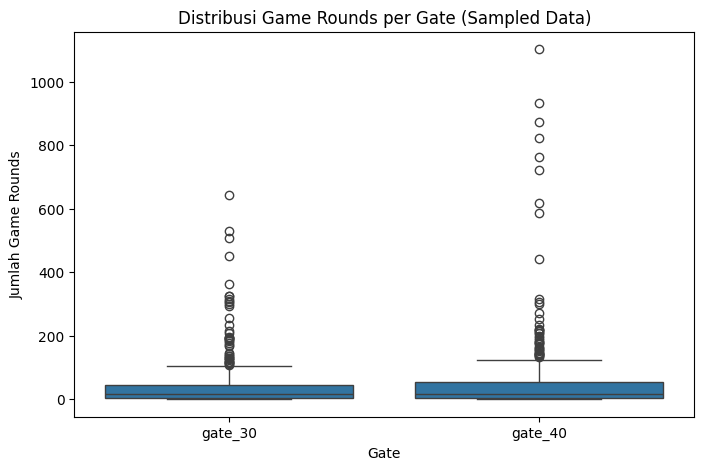

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.boxplot(x="version", y="sum_gamerounds", data=sample_df)
plt.xlabel("Gate")
plt.ylabel("Jumlah Game Rounds")
plt.title("Distribusi Game Rounds per Gate (Sampled Data)")
plt.show()

## Handling Outlier

### Interquartile Range (IQR)

In [ ]:
# Fungsi untuk mendeteksi outlier dengan IQR
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return lower_bound, upper_bound

# Hitung batas outlier untuk masing-masing grup
lb_30, ub_30 = detect_outliers_iqr(sample_df[sample_df["version"] == 'gate_30'], "sum_gamerounds")
lb_40, ub_40 = detect_outliers_iqr(sample_df[sample_df["version"] == 'gate_40'], "sum_gamerounds")

# Filter data yang tidak termasuk outlier
df_clean = sample_df[
    ((sample_df["version"] == 'gate_30') & (sample_df["sum_gamerounds"].between(lb_30, ub_30))) |
    ((sample_df["version"] == 'gate_40') & (sample_df["sum_gamerounds"].between(lb_40, ub_40)))
]

# Print jumlah outlier per grup
print(f"Jumlah outlier di gate_30: {len(sample_df[sample_df['version'] == 'gate_30']) - len(df_clean[df_clean['version'] == 'gate_30'])}")
print(f"Jumlah outlier di gate_40: {len(sample_df[sample_df['version'] == 'gate_40']) - len(df_clean[df_clean['version'] == 'gate_40'])}")

Jumlah outlier di gate_30: 40
Jumlah outlier di gate_40: 41


In [ ]:
df_clean.head()

,userid,version,sum_gamerounds,retention_1,retention_7
58980,6531033,gate_30,35,False,False
72247,8003009,gate_30,4,False,False
50215,5566807,gate_30,23,True,False
609,64235,gate_30,1,False,False
56038,6210551,gate_30,7,False,False


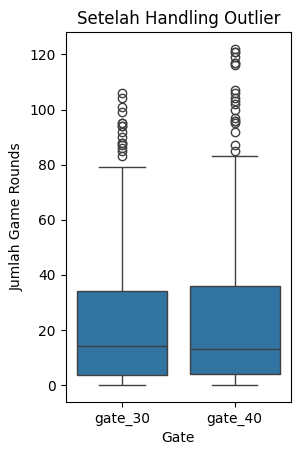

In [ ]:
plt.subplot(1,2,2)
sns.boxplot(x="version", y="sum_gamerounds", data=df_clean)  # Atau pakai sum_gamerounds_winsorized
plt.xlabel("Gate")
plt.ylabel("Jumlah Game Rounds")
plt.title("Setelah Handling Outlier")

plt.show()

Data berhimpitan dengan nilai maksimum dianggap wajar, karena nilainya mendekati nilai maksimum, sehingga tidak dianggap outlier.

## Pengujian Hipotesis

### Cek Normalitas

Hipotesis:
1. H0: Data Berdistribusi Normal
2. H1: Data Tidak Berdistribusi Normal

Alfa = 5%

Daerah Penolakan = Tolak H0, jika P-value < 5%

In [ ]:
from scipy.stats import kstest

In [ ]:
#Data Tanpa Outlier
stat, p = kstest(df_clean['sum_gamerounds'], 'norm')
print("p-value =", p)

p-value = 0.0


In [ ]:
#Data Sama Outlier
stat, p = kstest(sample_df['sum_gamerounds'], 'norm')
print("p-value =", p)

p-value = 0.0


karena Tanpa Outlier dan sama Outlier setelah dicek normalitas hasil P-value = 0 sehingga < 0,05 (alpha) maka Tolak H0 artinya data tidak berdistribusi normal. Dengan Demikian, kedua data tersebut nantinya pengujiannya menggunakan Uji Non parametrik Statistik untuk Hipotesis dua populasi yang berbeda. Pengujian yang dipake --> Uji Mann Whitney (Unpaired-test)

### Uji Mann Whitney

#### Uji Mann Whitney Untuk Data Sama Outlier

Hipotesis:
1. H0: Tidak ada perbedaan signifikan dalam jumlah ronde permainan antara gate_30 dan gate_40
2. H1: Ada perbedaan signifikan dalam jumlah ronde permainan antara gate_30 dan gate_40

Alfa = 5%

Daerah Penolakan = Tolak H0, jika P-value < 5%

In [ ]:
from scipy.stats import mannwhitneyu

# Misal data sudah dalam bentuk list
sum_gameround_gate_30 = sample_df.loc[sample_df["version"] == "gate_30", "sum_gamerounds"] #gate_30
sum_gameround_gate_40 = sample_df.loc[sample_df["version"] == "gate_40", "sum_gamerounds"] #gate_40

stat, p = mannwhitneyu(sum_gameround_gate_30, sum_gameround_gate_40, alternative='two-sided')

print("Mann-Whitney U Test p-value:", p)

if p > 0.05:
    print("Tidak ada perbedaan signifikan dalam jumlah ronde permainan antara gate_30 dan gate_40")
else:
    print("Ada perbedaan signifikan dalam jumlah ronde permainan antara gate_30 dan gate_40")

Mann-Whitney U Test p-value: 0.7689121002513506
Tidak ada perbedaan signifikan dalam jumlah ronde permainan antara gate_30 dan gate_40


#### Uji Mann Whitney Untuk Data tanpa Outlier

Hipotesis:
1. H0: Tidak ada perbedaan signifikan dalam jumlah ronde permainan antara gate_30 dan gate_40
2. H1: Ada perbedaan signifikan dalam jumlah ronde permainan antara gate_30 dan gate_40

Alfa = 5%

Daerah Penolakan = Tolak H0, jika P-value < 5%

In [ ]:
from scipy.stats import mannwhitneyu

# Misal data sudah dalam bentuk list
sum_gameround_gate_30 = df_clean.loc[df_clean["version"] == "gate_30", "sum_gamerounds"] #gate_30
sum_gameround_gate_40 = df_clean.loc[df_clean["version"] == "gate_40", "sum_gamerounds"] #gate_40

stat, p = mannwhitneyu(sum_gameround_gate_30, sum_gameround_gate_40, alternative='two-sided')

print("Mann-Whitney U Test p-value:", p)

if p > 0.05:
    print("Tidak ada perbedaan signifikan dalam jumlah ronde permainan antara gate_30 dan gate_40")
else:
    print("Ada perbedaan signifikan dalam jumlah ronde permainan antara gate_30 dan gate_40")

Mann-Whitney U Test p-value: 0.8454702076397356
Tidak ada perbedaan signifikan dalam jumlah ronde permainan antara gate_30 dan gate_40


# Interpretasi/Kesimpulan + Saran/Rekomendasi

Karena dari hasil Pengujian Hipotesis secara statistik untuk yang **data outlier maupun tanpa outlier**, didapatkan bahwa **Tolak H0** dengan Uji Mann Whitney. Maka, **gate_30 dan gate_40 tidak memiliki dampak yang berbeda terhadap jumlah ronde permainan pemain**.

Adapun kesimpulan Bisnis :
1. Perubahan dari gate_30 ke gate_40 tidak memengaruhi jumlah ronde permainan
secara signifikan → **Jika tujuan eksperimen adalah meningkatkan engagement, maka perubahan ini tidak memberikan dampak yang diharapkan**.
2. Tidak ada risiko besar dalam mempertahankan versi mana pun → Karena tidak ada perbedaan signifikan, **perusahaan bisa memilih untuk mempertahankan gate_30 atau gate_40 berdasarkan faktor lain** (misalnya, kemudahan implementasi atau biaya operasional).
3. Mungkin ada faktor lain yang lebih berpengaruh terhadap jumlah ronde permainan → Fitur lain dalam game, mekanisme reward, atau pengalaman pengguna mungkin lebih berperan dibanding sekadar perbedaan gate.

Saran/Rekomendasi:
1. Mengevaluasi Faktor lain yang bisa memengaruhi jumlah Ronde, mungkin menunjukkan perubahan gate tidak cukup.
2. Bisa melakukan segmentasi data, terkait pola datanya seperti, sehingga bisa diketahui efek perubahannya. Salah satu contoh: **efek perubahan gate hanya terasa pada kelompok pemain tertentu (pemain lama vs pemain baru atau pemain remaja vs pemain anak-anak)**
3. Bisa melakukan pengujian lain yang lebih **spesifik**, dari sisi reward milestone, dari sisi misi atau tantangan, atau dari fitur gamenya.
4. Perusahaan sebaiknya **mempertimbangkan faktor lain** sebelum memutuskan apakah ingin mempertahankan atau mengubah sistem gate